Back to the main [Index](index.ipynb) <a id="top"></a>

# Post-processing tools for electron band energies

In this notebook we discuss how to plot electron band structures and density of states (DOS) 
using the netcdf files produced by Abinit. 

For the tutorial, we will use the netcdf files shipped with AbiPy. 
The function `abidata.ref_file` returns the absolute path of the reference file. 
In your scripts, you have to replace `data.ref_file("abipy_filename")` with a string giving
the location of your netcdf file.
    
Alteratively, one can use the `abiopen.py` script to open the file inside the shell with the syntax:

    abiopen.py out_GSR.nc 
    
This command will start the ipython interpreter so that one can interact directly 
with the `GsrFile` object (named `abifile` inside ipython).
To generate a jupyter notebook use:

    abiopen.py out_GSR.nc -nb
      
For a quick visualization of the data, use:

    abiview.py ebands out_GSR.nc
    

## Table of Contents
[[back to top](#top)]

- [The GSR File](#The-GSR-File)
- [Plotting band structures](#Plotting-band-structures)
- [DOS with the Gaussian technique](#DOS-with-the-Gaussian-technique)
- [Joint density of states](#Joint-density-of-states)
- [Plotting the Fermi surface](#Plotting-the-Fermi-surface)
- [Analyzing multiple GSR files with robots](#Analyzing-multiple-GSR-files-with-robots)

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import division, print_function, unicode_literals

import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook
# Import abipy reference data.
import abipy.data as abidata

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

## The GSR File
[[back to top](#top)]

The `GSR` file (mnemonics: Ground-State Results) is a netcdf file with the 
results produced by SCF or NSCF ground-state calculations 
(band energies, forces, energies, stress tensor).
To open a `GSR` file, use the `abiopen` function defined in `abilab`:

In [2]:
gsr = abilab.abiopen(abidata.ref_file("si_scf_GSR.nc"))

The gsr object has a `Structure`:

In [3]:
print(gsr.structure)

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------------------------------------------
  0  Si    0     0     0     [-5.89948302e-27 -1.93366148e-27  2.91016902e-27] eV ang^-1
  1  Si    0.25  0.25  0.25  [ 5.89948302e-27  1.93366148e-27 -2.91016902e-27] eV ang^-1

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True


and and `ElectronBands` object with the band energies, the occupation factors, the list of k-points:

In [4]:
print(gsr.ebands)

================================= Structure =================================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------------------------------------------
  0  Si    0     0     0     [-5.89948302e-27 -1.93366148e-27  2.91016902e-27] eV ang^-1
  1  Si    0.25  0.25  0.25  [ 5.89948302e-27  1.93366148e-27 -2.91016902e-27] eV ang^-1

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

Number of electrons: 8.0, Fermi level: 5.598 [eV]
nsppol: 1, nkpt: 29, mband: 8, nspinor: 1, nspden: 1
smearing scheme: none, tsmear_eV: 0.272, occopt: 1
Direct gap:
    Energy: 2.532 [eV]
    Initial state: spin=0, kpt=[+0.000, +0.000, +0.000], weight: 0.002, band=3, eig=5.598, occ=2.000
    Final state:   spin=0, kpt=[+0.000, +0.000, +0.000], weight: 0.002, band=4, eig=8.130, 

<div class="alert alert-danger" role="alert">
In python we start to count from zero, thus the first band has index 0 and the first spin is 0
AbiPy uses the same convention so be very careful when specifying band, spin or k-point indices. 
</div>

A GSR file produced by a **self-consistent run**, contains the values of the total energy, the forces,
and the stress tensor at the end of the SCF cycle:

In [5]:
print("energy:", gsr.energy, "pressure:", gsr.pressure)

energy: -241.23646831544198 eV pressure: -5.211621507646274 GPa


To get a summary of the most important results:

In [6]:
print(gsr)

================================= File Info =================================
Name: si_scf_GSR.nc
Directory: /Users/gmatteo/git_repos/abipy/abipy/data/refs/si_ebands
Size: 14.83 kb
Access Time: Fri Mar 16 20:57:51 2018
Modification Time: Wed Nov  8 01:06:20 2017
Change Time: Wed Nov  8 01:06:20 2017

================================= Structure =================================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------------------------------------------
  0  Si    0     0     0     [-5.89948302e-27 -1.93366148e-27  2.91016902e-27] eV ang^-1
  1  Si    0.25  0.25  0.25  [ 5.89948302e-27  1.93366148e-27 -2.91016902e-27] eV ang^-1

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

Stress tensor (Cartesian coordinates in Ha/Bohr**3):
[[1.77139311e-04 2.6730973

The different contributions to the total energy are stored in a dictionary:

In [7]:
print(gsr.energy_terms)

+----------------------+------------------------+
|         Term         |         Value          |
+----------------------+------------------------+
|      e_localpsp      | -68.62575616682041 eV  |
|    e_eigenvalues     |  4.453251781809304 eV  |
|       e_ewald        | -226.94266538122858 eV |
|      e_hartree       | 14.989583868349118 eV  |
|      e_corepsp       |  2.262480246606245 eV  |
|     e_corepspdc      |         0.0 eV         |
|      e_kinetic       |  80.6603511758275 eV   |
|    e_nonlocalpsp     |  52.15353045099117 eV  |
|      e_entropy       |         0.0 eV         |
|       entropy        |         0.0 eV         |
|         e_xc         | -95.73399250916707 eV  |
|        e_xcdc        |         0.0 eV         |
|        e_paw         |         0.0 eV         |
|       e_pawdc        |         0.0 eV         |
|     e_elecfield      |         0.0 eV         |
|      e_magfield      |         0.0 eV         |
|       e_fermie       | 5.5984532787385985 eV  |


At this point, we don't need this file anymore so we close it with:

In [8]:
gsr.close()

<div class="alert alert-danger" role="alert">
The gsr maintains a reference to the underlying netcdf file hence one should
call `gsr.close()` to release the resource when we don't need it anymore.
Python will do it automatically if you use `abiopen` and the `with` context manager.

Note that we don't always follow this rule inside the jupyter notebook to maintain the
code readable but you should definitively close all your files, especially when
writing code that may be running for hours or even more.
</div>

## Plotting band structures
[[back to top](#top)]

Let's open the GSR file produced by a NSCF calculation done on a high-symmetry k-path
and extract the electronic band structure.

In [9]:
with abilab.abiopen(abidata.ref_file("si_nscf_GSR.nc")) as nscf_gsr:
    ebands_kpath = nscf_gsr.ebands

Now we can plot the band energies with: 

<IPython.core.display.Javascript object>


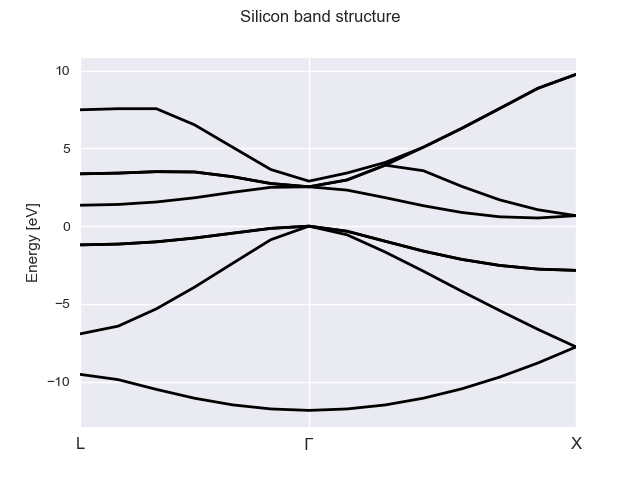

In [10]:
# The labels for the k-points are found in an internal database.
ebands_kpath.plot(title="Silicon band structure");

Alternatively you can use the optional argument `klabels` to define the mapping `reduced_coordinates --> name of the k-point` and pass it to the plot method

In [11]:
klabels = {
    (0.5, 0.0, 0.0): "L",
    (0.0, 0.0, 0.0): "$\Gamma$",
    (0.0, 0.5, 0.5): "X"
}

# ebands_kpath.plot(title="User-defined k-labels", band_range=(0, 5), klabels=klabels);

Let's have a look at our k-points by calling `kpoints.plot()`

<IPython.core.display.Javascript object>


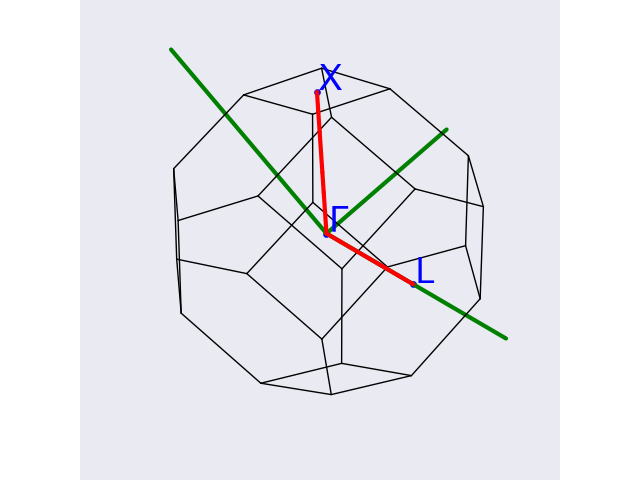

In [12]:
ebands_kpath.kpoints.plot();

and the crystalline structure with:

<IPython.core.display.Javascript object>


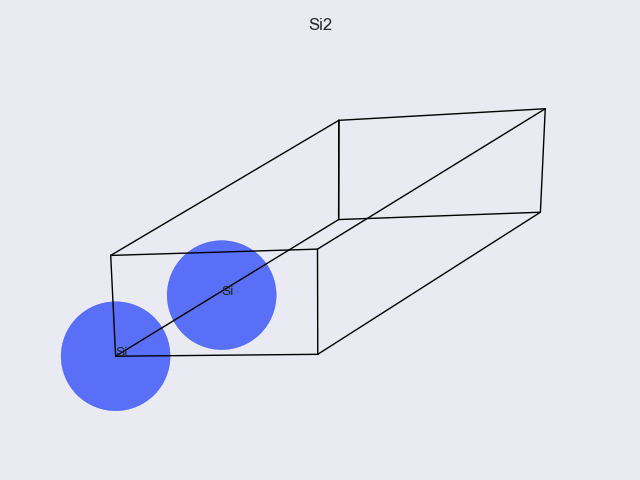

In [13]:
ebands_kpath.structure.plot();

 <div class="alert alert-success">
The same piece of code works if you replace the `GSR.nc` file with e.g. a `WFK.nc` file in netcdf format
(actually any netcdf file with an ebands object).
The main advantage of the `GSR` file is that it is lightweight (no wavefunctions).
</div>

## DOS with the Gaussian technique
[[back to top](#top)]

Let's use the eigenvalues and the k-point weights stored in `gs_ebands` to
compute the DOS with the Gaussian method.
The method is called without arguments so we use default values 
for the broadening and the step of the linear mesh.

In [14]:
 with abilab.abiopen(abidata.ref_file("si_scf_GSR.nc")) as scf_gsr:
    ebands_kmesh = scf_gsr.ebands

edos = ebands_kmesh.get_edos()
print(edos)

nsppol: 1, nelect: 8.0
Fermi energy: 5.839906241274078 [eV] (recomputed from nelect):


<IPython.core.display.Javascript object>


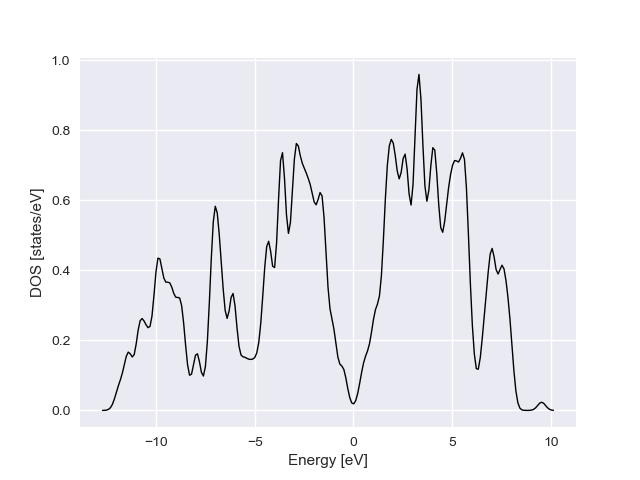

In [15]:
edos.plot();

In [16]:
print("[ebands_kmesh] is_ibz:", ebands_kmesh.kpoints.is_ibz, "is_kpath:", ebands_kmesh.kpoints.is_path)
print("[ebands_kpath] is_ibz:", ebands_kpath.kpoints.is_ibz, "is_kpath:", ebands_kpath.kpoints.is_path)

[ebands_kmesh] is_ibz: True is_kpath: False
[ebands_kpath] is_ibz: False is_kpath: True


<div class="alert alert-info" role="alert">
The DOS requires a homogeneous $k$-sampling of the BZ. Abipy will raise an exception if you try 
to compute the DOS with a k-path.
</div>

To plot bands and DOS on the same figure:

<IPython.core.display.Javascript object>


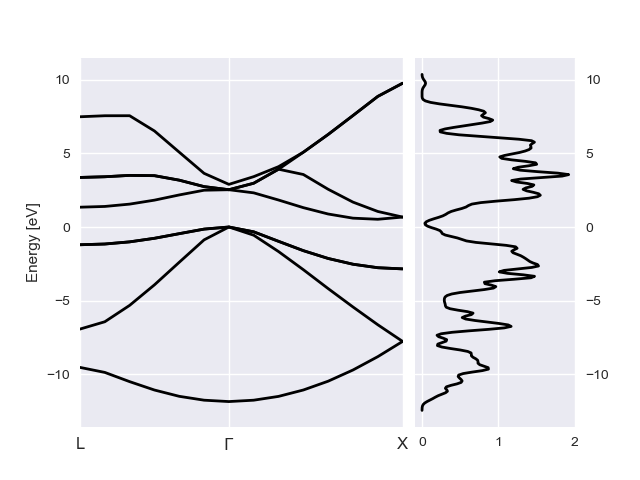

In [17]:
ebands_kpath.plot_with_edos(edos);

To plot the DOS and the integrated DOS (IDOS), use:

<IPython.core.display.Javascript object>


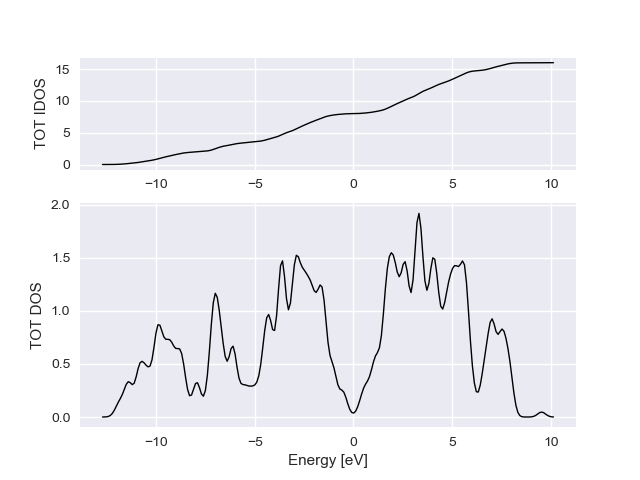

In [18]:
edos.plot_dos_idos();

The gaussian broadening can significantly change the overall shape of the DOS.
If accurate values are needed (e.g. the DOS at the Fermi level in metals),
one should perform an accurate convergence study wrt to the k-point mesh.
Here we show how compute the DOS with different values of the gaussian smearing 
for fixed k-point sampling and plot the results:

In [19]:
# Compute the DOS with the Gaussian method and different values of the broadening
widths = [0.1, 0.2, 0.3, 0.4]

edos_plotter = ebands_kmesh.compare_gauss_edos(widths, step=0.1)

To plot the results on the same figure, use:

<IPython.core.display.Javascript object>


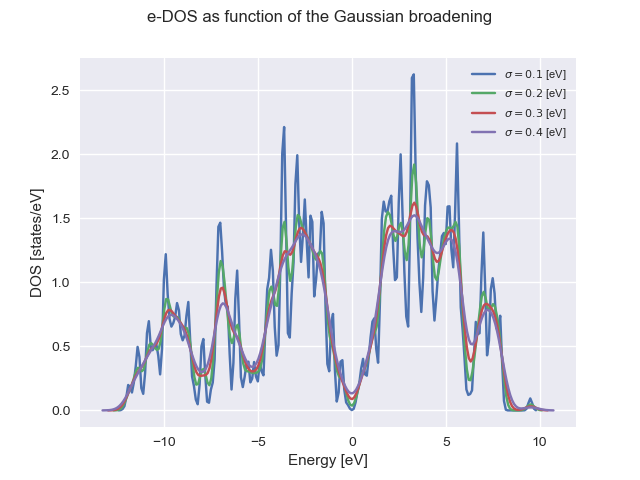

In [20]:
edos_plotter.combiplot(title="e-DOS as function of the Gaussian broadening");

while `gridplot` generates a grid of subplots:

<IPython.core.display.Javascript object>


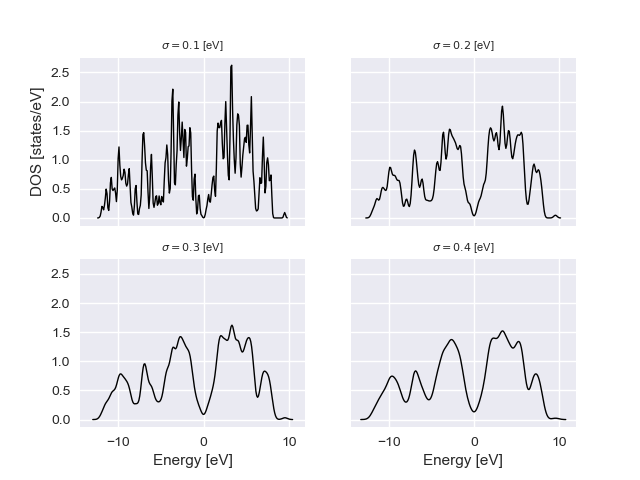

In [21]:
edos_plotter.gridplot();

## Joint density of states
[[back to top](#top)]

This example shows how plot the different contributions to the electronic joint density of states of Silicon.
Select the valence and conduction bands to include in the JDOS. Here we include valence bands from 0 to 3 and the first conduction band (4).

<IPython.core.display.Javascript object>


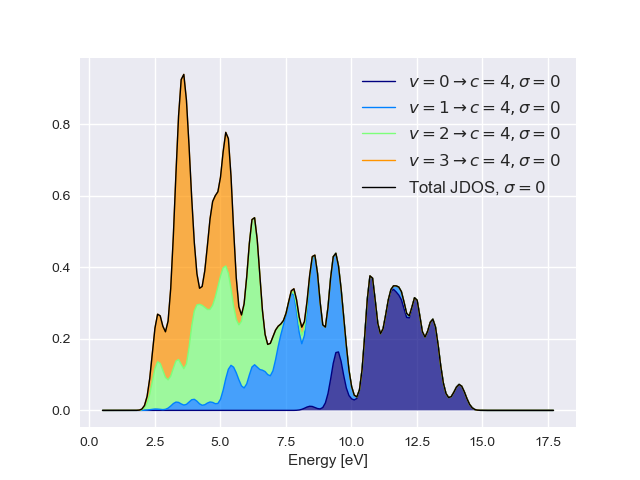

In [22]:
vrange = range(0,4)
crange = range(4,5)

# Plot data
ebands_kmesh.plot_ejdosvc(vrange, crange);

<IPython.core.display.Javascript object>


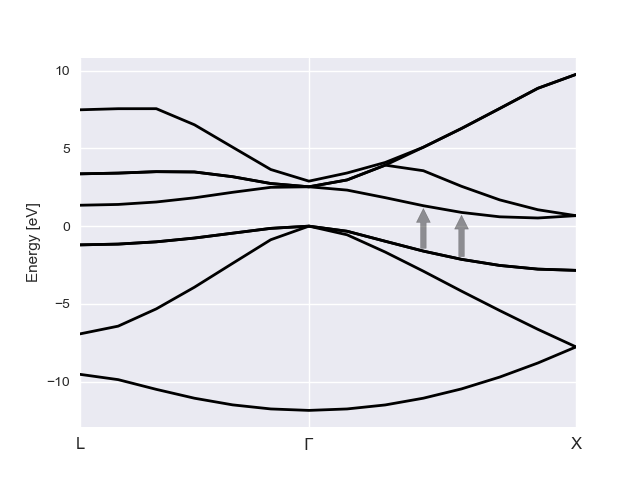

In [23]:
ebands_kpath.plot_transitions(omega_ev=3.0);

<IPython.core.display.Javascript object>


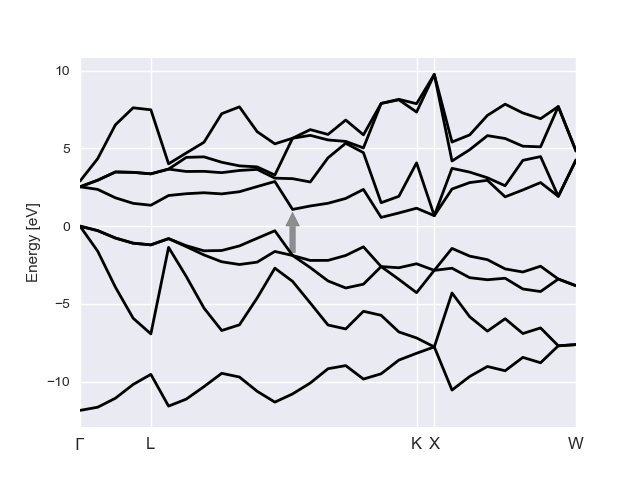

In [24]:
ebands_kmesh.plot_transitions(omega_ev=3.0);

## Plotting the Fermi surface
[[back to top](#top)]

In [25]:
with abilab.abiopen(abidata.ref_file("mgb2_kmesh181818_FATBANDS.nc")) as fbnc_kmesh:
    mgb2_ebands = fbnc_kmesh.ebands
    
    # Build ebands in full BZ.
    mgb2_eb3d = mgb2_ebands.get_ebands3d()

There are three bands crossing the Fermi level of $MgB_2$ (band 2, 3, 4):

<IPython.core.display.Javascript object>


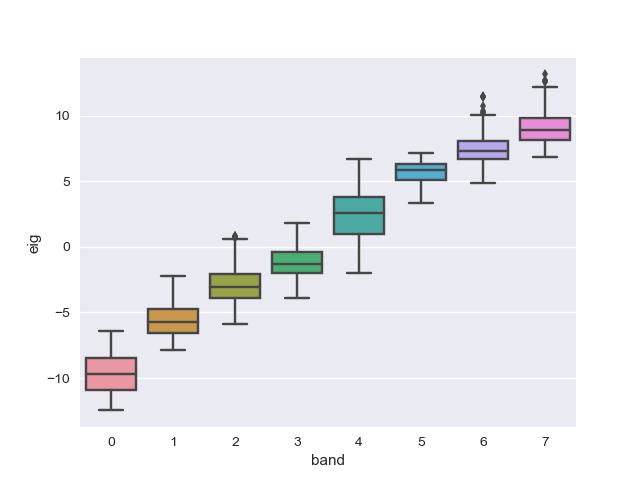

In [26]:
mgb2_ebands.boxplot();

Let's use matplotlib to plot the isosurfaces corresponding to the Fermi level (default):

<IPython.core.display.Javascript object>


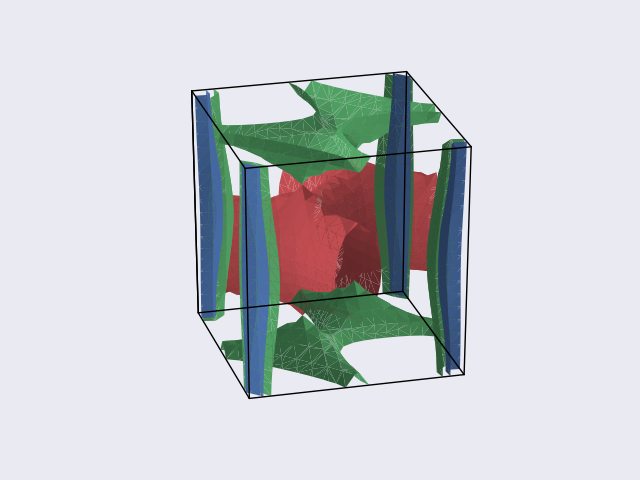

In [27]:
# Warning: requires skimage package, rendering could be slow.
mgb2_eb3d.plot_isosurfaces();

In [28]:
#ebands_kpath.plot_scatter3d(band=3);
#ebands_kmesh.plot_scatter3d(band=3);

## Analyzing multiple GSR files with robots
[[back to top](#top)]

TODO

<div class="alert alert-info" role="alert">
Robots can also be constructed from the command line with: abicomp.py gsr FILES
</div>

Back to the main [Index](index.ipynb)